## Initialize

In [1]:
%reload_ext autoreload
%autoreload 2

In [59]:
from pathlib import  Path
import pandas as pd
import numpy as np
import plotly as pl, plotly_express as pe
from src.utils import add_datepart, apply_cats, get_cv_idxs, proc_df

data = Path('/tmp//myapp/data')
data.exists()

True

## Collab settings

In [69]:
# connect to google drive first
data = Path('/content/drive/MyDrive/data/data_rossmann')
print(data.exists())
src_path = Path('/content/drive/MyDrive/src/src_rossmann/')
print(src_path.exists())

True
True


In [70]:
!cp -r {src_path} .

In [ ]:
!pip install -r {src_path.name}/requirements.txt

In [72]:
#from src_rossmann.structured import *
#from src_rossmann.column_data import *


## Reading data

In [3]:
files = sorted(data.glob('*.csv'))
tables = [pd.read_csv(f, low_memory=False) for f in files]

googletrend, sample, state_names, store, store_states, test, train, weather = tables

# 1 Data Preprocessing

## 01 Cleaning Data

In [4]:
train.StateHoliday = train.StateHoliday!='0'
test.StateHoliday  = test.StateHoliday!='0'

In [5]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))

In [6]:
weather = join_df(weather, state_names, "file", "StateName")

In [7]:
googletrend['Date'] = googletrend.week.str.split(' - ', expand=True)[0]
googletrend['State'] = googletrend.file.str.split('_', expand=True)[2]
googletrend.loc[googletrend.State=='NI', "State"] = 'HB,NI'

In [8]:
add_datepart(weather, "Date", drop=False)
add_datepart(googletrend, "Date", drop=False)
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)

/tmp/myapp/src/utils.py:71: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  for n in attr: df[targ_pre + n] = getattr(fld.dt, n.lower())


In [9]:
trend_de = googletrend[googletrend.file == 'Rossmann_DE']

In [10]:
store = join_df(store, store_states, "Store")
len(store[store.State.isnull()])

0

In [11]:
joined = join_df(train, store, "Store")
joined_test = join_df(test, store, "Store")
len(joined[joined.StoreType.isnull()]),len(joined_test[joined_test.StoreType.isnull()])

(0, 0)

In [12]:
joined = join_df(joined, googletrend, ["State","Year", "Week"])
joined_test = join_df(joined_test, googletrend, ["State","Year", "Week"])
len(joined[joined.trend.isnull()]),len(joined_test[joined_test.trend.isnull()])

(0, 0)

In [13]:
joined = joined.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
joined_test = joined_test.merge(trend_de, 'left', ["Year", "Week"], suffixes=('', '_DE'))
len(joined[joined.trend_DE.isnull()]),len(joined_test[joined_test.trend_DE.isnull()])

(0, 0)

In [14]:
joined = join_df(joined, weather, ["State","Date"])
joined_test = join_df(joined_test, weather, ["State","Date"])
len(joined[joined.Mean_TemperatureC.isnull()]),len(joined_test[joined_test.Mean_TemperatureC.isnull()])

(0, 0)

In [15]:
for df in (joined, joined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns: df.drop(c, inplace=True, axis=1)

In [16]:
for df in (joined,joined_test):
    df['CompetitionOpenSinceYear'] = df.CompetitionOpenSinceYear.fillna(1900).astype(np.int32)
    df['CompetitionOpenSinceMonth'] = df.CompetitionOpenSinceMonth.fillna(1).astype(np.int32)
    df['Promo2SinceYear'] = df.Promo2SinceYear.fillna(1900).astype(np.int32)
    df['Promo2SinceWeek'] = df.Promo2SinceWeek.fillna(1).astype(np.int32)

In [17]:
for df in (joined,joined_test):
    df["CompetitionOpenSince"] = pd.to_datetime(dict(year=df.CompetitionOpenSinceYear, 
                                                     month=df.CompetitionOpenSinceMonth, day=15))
    df["CompetitionDaysOpen"] = df.Date.subtract(df.CompetitionOpenSince).dt.days

In [18]:
for df in (joined,joined_test):
    df.loc[df.CompetitionDaysOpen<0, "CompetitionDaysOpen"] = 0
    df.loc[df.CompetitionOpenSinceYear<1990, "CompetitionDaysOpen"] = 0

Treat variables as categorical as possible

In [19]:
for df in (joined,joined_test):
    df["CompetitionMonthsOpen"] = df["CompetitionDaysOpen"]//30
    df.loc[df.CompetitionMonthsOpen>24, "CompetitionMonthsOpen"] = 24
joined.CompetitionMonthsOpen.unique()

array([24,  3, 19,  9,  0, 16, 17,  7, 15, 22, 11, 13,  2, 23, 12,  4, 10,
        1, 14, 20,  8, 18,  6, 21,  5])

In [20]:
from datetime import datetime, timedelta, date
def first_date(year, week):
    ret = datetime.strptime('%04d-%02d-1' % (year, week), '%Y-%W-%w')
    if date(year, 1, 4).isoweekday() > 4:
        ret -= timedelta(days=7)
    return ret

In [21]:
for df in (joined,joined_test):
    df["Promo2Since"] = pd.to_datetime(df.apply(lambda x: first_date(
        x.Promo2SinceYear, x.Promo2SinceWeek), axis=1))
    df["Promo2Days"] = df.Date.subtract(df["Promo2Since"]).dt.days

In [22]:
for df in (joined,joined_test):
    df.loc[df.Promo2Days<0, "Promo2Days"] = 0
    df.loc[df.Promo2SinceYear<1990, "Promo2Days"] = 0
    df["Promo2Weeks"] = df["Promo2Days"]//7
    df.loc[df.Promo2Weeks<0, "Promo2Weeks"] = 0
    df.loc[df.Promo2Weeks>25, "Promo2Weeks"] = 25
    df.Promo2Weeks.unique()

In [23]:
joined.to_parquet(data / 'joined.p')
joined_test.to_parquet(data / 'joined_test.p')

train.to_parquet(data / 'train.p')
test.to_parquet(data / 'test.p')

## 02 Exploration of cleaned data

In [11]:
joined = pd.read_parquet(data / 'joined.p')
joined_test = pd.read_parquet(data / 'joined_test.p')

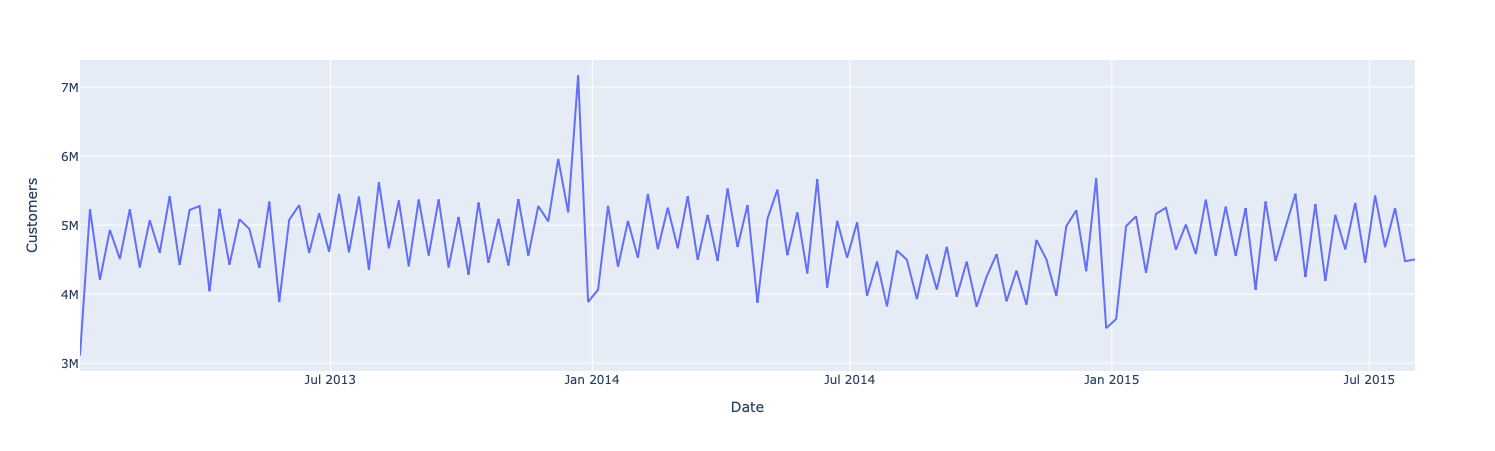

In [12]:
joined_W = joined.set_index('Date').resample('W')['Customers'].sum().reset_index()
pe.line(data_frame=joined_W, x='Date',y='Customers')

## 03 Adding durations

In [24]:
joined       = pd.read_parquet(data / 'joined.p')
joined_test  = pd.read_parquet(data / 'joined_test.p')

train = pd.read_parquet(data  / 'train.p')
test = pd.read_parquet(data / 'test.p')

In [25]:
def get_elapsed(fld, pre):
    day1 = np.timedelta64(1, 'D')
    last_date = np.datetime64()
    last_store = 0
    res = []

    for s,v,d in zip(df.Store.values,df[fld].values, df.Date.values):
        if s != last_store:
            last_date = np.datetime64()
            last_store = s
        if v: last_date = d
        res.append(((d-last_date).astype('timedelta64[D]') / day1))
    df[pre+fld] = res

In [27]:
columns = ["Date", "Store", "Promo", "StateHoliday", "SchoolHoliday"]
df = train[columns].append(test[columns])

In [28]:
fld = 'SchoolHoliday'
df = df.sort_values(['Store', 'Date'],)
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

fld = 'StateHoliday'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

fld = 'Promo'
df = df.sort_values(['Store', 'Date'])
get_elapsed(fld, 'After')
df = df.sort_values(['Store', 'Date'], ascending=[True, False])
get_elapsed(fld, 'Before')

In [29]:
df = df.set_index("Date")

In [30]:
columns = ['SchoolHoliday', 'StateHoliday', 'Promo']
for o in ['Before', 'After']:
    for p in columns:
        a = o+p
        df[a] = df[a].fillna(0).astype(int)

In [31]:
bwd = df[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()
fwd = df[['Store']+columns].sort_index(ascending=False
                                      ).groupby("Store").rolling(7, min_periods=1).sum()
bwd.drop('Store',1,inplace=True)
bwd.reset_index(inplace=True)
fwd.drop('Store',1,inplace=True)
fwd.reset_index(inplace=True)

In [32]:
df = df.merge(bwd, 'left', ['Date', 'Store'], suffixes=['', '_bw'])
df = df.merge(fwd, 'left', ['Date', 'Store'], suffixes=['', '_fw'])

In [33]:
df.drop(columns,1,inplace=True)

In [34]:
joined = join_df(joined, df, ['Store', 'Date'])
joined_test = join_df(joined_test, df, ['Store', 'Date'])

In [35]:
joined = joined[joined.Sales!=0]

In [36]:
joined.reset_index(inplace=True)
joined_test.reset_index(inplace=True)

In [37]:
joined.to_parquet(data / 'joined.p')
joined_test.to_parquet(data / 'joined_test.p')

# 2 Modelling

## 01 Create Feaures for modelling

In [38]:
joined      = pd.read_parquet(data / 'joined.p')
joined_test = pd.read_parquet(data / 'joined_test.p')

In [39]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

contin_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

n = len(joined); print(n)

844338


In [40]:
dep = 'Sales'
joined = joined[cat_vars+contin_vars+[dep, 'Date']].copy()

joined_test[dep] = 0
joined_test = joined_test[cat_vars+contin_vars+[dep, 'Date', 'Id']].copy()

In [43]:
for v in cat_vars: 
    joined[v] = joined[v].astype('category').cat.as_ordered()
apply_cats(joined_test, joined)

In [44]:
for v in contin_vars:
    joined[v] = joined[v].fillna(0).astype('float32')
    joined_test[v] = joined_test[v].fillna(0).astype('float32')

In [49]:
# SAMPLE DATA
idx_samp = get_cv_idxs(n, val_pct=150000/n)
joined_samp = joined.iloc[idx_samp].set_index("Date")
samp_size = len(joined_samp); 
print(samp_size)

150000


In [95]:
# FULL DATA
samp_size = n
joined_samp = joined.set_index("Date")

In [61]:
df, y, nas, mapper = proc_df(joined_samp, 'Sales', do_scale=True)
yl = np.log(y)

In [62]:
joined_test = joined_test.set_index("Date")
df_test, _, nas, mapper = proc_df(joined_test, 'Sales', do_scale=True, skip_flds=['Id'],
                                  mapper=mapper, na_dict=nas)

In [65]:
train_ratio = 0.75
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); print(train_size)
val_idx = list(range(train_size, len(df)))

112500


In [75]:
# val_idx = np.flatnonzero(
#    (df.index<=datetime.datetime(2014,9,17)) & (df.index>=datetime.datetime(2014,8,1)))

In [99]:
val_idx = [0] # for training on all data

In [71]:
df.shape

(150000, 38)

## DL

In [76]:
def inv_y(a): return np.exp(a)

def exp_rmspe(y_pred, targ):
    targ = inv_y(targ)
    pct_var = (targ - inv_y(y_pred))/targ
    return math.sqrt((pct_var**2).mean())

max_log_y = np.max(yl)
y_range = (0, max_log_y*1.2)

In [102]:
# ColumnarModelData  
#            -> trn_ds, val_ds, test_ds as ColumnarDataset 
#            -> trn_dl, val_dl, test_dl as DataLoader

md = ColumnarModelData.from_data_frame(data, val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=128,
                                       test_df=df_test)

In [59]:
md.trn_dl.get_batch([0,1])

[array([[257,   2,   3,   6,  16,   1,  25,   1,   1,   1,   0,  20,   1,   1,  25,  11,   5,   3,   1,   1,
           1,   1],
        [  4,   3,   1,  10,  30,   1,  25,   1,   3,   3,   0,  17,   1,   1,  44,   0,   3,   3,   1,   1,
           1,   1]]),
 array([[-0.64544,  0.07173,  0.12119,  0.16517, -0.03372, -1.05369, -0.75643, -0.5195 , -0.65139,  0.41326,
         -0.19436,  0.48731, -0.52508,  1.12874,  1.11577, -0.48908],
        [-0.6196 , -0.16343, -0.15423, -0.1437 , -0.80938, -0.14708, -0.09598,  0.70453,  0.70053, -1.40058,
          0.76991, -0.02601, -0.36398, -0.5915 , -0.89624, -0.48908]], dtype=float32),
 array([[8.68845],
        [8.96188]], dtype=float32)]

In [103]:
cat_sz = [(c, len(joined_samp[c].cat.categories)+1) for c in cat_vars]

In [104]:
emb_szs = [(c, min(50, (c+1)//2)) for _,c in cat_sz]

In [24]:
class MixedInputModel(nn.Module):
    def __init__(self, emb_szs, n_cont, emb_drop, out_sz, szs, drops,
                 y_range=None, use_bn=False):
        super().__init__()
        self.embs = nn.ModuleList([nn.Embedding(c, s) for c,s in emb_szs])
        for emb in self.embs: emb_init(emb)
        n_emb = sum(e.embedding_dim for e in self.embs)

        szs = [n_emb+n_cont] + szs
        self.lins = nn.ModuleList([
            nn.Linear(szs[i], szs[i+1]) for i in range(len(szs)-1)])
        self.bns = nn.ModuleList([
            nn.BatchNorm1d(sz) for sz in szs[1:]])
        for o in self.lins: kaiming_normal_(o.weight.data)
        self.outp = nn.Linear(szs[-1], out_sz)
        kaiming_normal_(self.outp.weight.data)

        self.emb_drop = nn.Dropout(emb_drop)
        self.drops = nn.ModuleList([nn.Dropout(drop) for drop in drops])
        self.bn = nn.BatchNorm1d(n_cont)
        self.use_bn,self.y_range = use_bn,y_range

    def forward(self, x_cat, x_cont):
        x = [e(x_cat[:,i]) for i,e in enumerate(self.embs)]
        x = torch.cat(x, 1)
        x2 = self.bn(x_cont)
        x = self.emb_drop(x)
        x = torch.cat([x, x2], 1)
        for l,d,b in zip(self.lins, self.drops, self.bns):
            x = F.relu(l(x))
            if self.use_bn: x = b(x)
            x = d(x)
        x = self.outp(x)
        if self.y_range:
            x = F.sigmoid(x)
            x = x*(self.y_range[1] - self.y_range[0])
            x = x+self.y_range[0]
        return x


In [62]:
model = MixedInputModel(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)

In [105]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [74]:
m.lr_find()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


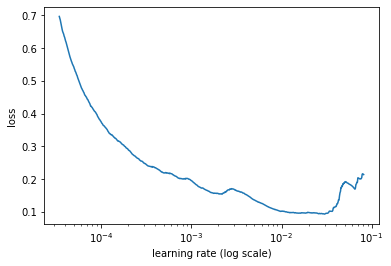

In [75]:
m.sched.plot(100)

## Fitting


In [106]:
m.fit(lr, 1, metrics=[exp_rmspe])

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss: 0.01506121229910201
[0.      0.01506 0.00617 0.07557]



In [108]:
x,y=m.predict_with_targs()
exp_rmspe(x,y)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


0.07557094866464054

In [109]:
m.fit(lr, 5, metrics=[exp_rmspe], cycle_len=1)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss: 0.009169354523757294
[0.      0.00917 0.00071 0.02695]
loss: 0.008261573542778513
[1.      0.00826 0.00131 0.03688]
loss: 0.008288355849829593
[2.      0.00829 0.00085 0.02959]
loss: 0.0073642891562459446
[3.      0.00736 0.00001 0.00228]
loss: 0.007265492321423075
[4.      0.00726 0.00051 0.02285]



In [112]:
m.fit(lr, 2, metrics=[exp_rmspe], cycle_len=1)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


loss: 0.007612567347444648
[0.      0.00761 0.00021 0.01456]
loss: 0.00694067611385988
[1.      0.00694 0.00052 0.02313]



In [113]:
x,y=m.predict_with_targs()

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1639: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [114]:
exp_rmspe(x,y)

0.02312771643087797

In [115]:
m.save('val0')